# Modelo incondicional [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/chcomin/curso-visao-computacional-2024/blob/main/M11_geracao_de_imagens/1%20-%20Modelo%20incondicional%20\(GPU\).ipynb)

A geração de imagens incondicional envolve gerar imagens similares às imagens da base de treinamento sem qualquer entrada adicional como um texto indicando o que deve ser gerado. O modelo simplesmente gera imagens aleatórias, a imagem a ser gerada depende da semente utilizada no ruído inicial.

### Importação das bibliotecas e criação do dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets

class FashionMNIST(datasets.FashionMNIST):
    '''Dataset que retorna apenas a imagem do FashionMNIST (sem o target).
    Precisamos usar o mesmo nome de classe porque o código do FashionMNIST
    usa o nome da classe para fazer algumas checagens.'''
    
    def __getitem__(self, idx):
        img, _ = super().__getitem__(idx)
        return img

def transform(img):
    img = torch.from_numpy(np.array(img, dtype=np.float32))
    # O padding é necessário porque o modelo que usaremos necessita de imagens com 
    # no mínimo tamanho 32x32
    img = F.pad(img, (2,2,2,2))
    # Normaliza entre [-0.5,0.5]
    img = img/255 - 0.5
    img = img.reshape(1, img.shape[0], img.shape[1])

    return img

def show_images(imgs, titles):

    fig, axs = plt.subplots(1, 6, figsize=(12,2))
    axs = axs.reshape(-1)
    for img, title, ax in zip(imgs, titles, axs):
        ax.imshow(img[0], 'gray')
        ax.set_title(title.item(), size=10)

ds = FashionMNIST('../data', transform=transform)

### Definição do scheduler de ruído

O Scheduler define a quantidade de ruído que será adicionada a cada passo do processo de difusão. Conhecendo quais foram os ruídos adicionados, é possível reverter o processo de difusão e gerar uma imagem a partir de um ruído!

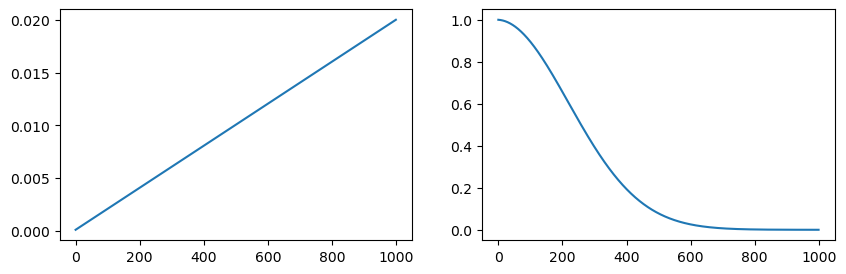

In [2]:
class Scheduler:
    '''Implementa o scheduler DDPM do artigo Denoising Diffusion Probabilistic 
    Models
    https://arxiv.org/abs/2006.11239
    Foi utilizada a notação e equações do capítulo 18 do livro Understanding 
    Deep Learning do Simon Prince.
    '''

    def __init__(self, n_steps=1000, beta_start=0.0001, beta_end=0.02):
        """
        Args:
            n_steps: número de passos do scheduler
            beta_start: variância inicial do ruído
            beta_end: variância final do ruído
        """

        # Variâncias dos ruídos (quantidade de ruído em cada passo)
        betas = torch.linspace(beta_start, beta_end, n_steps)
        # Produto acumulado de 1-variância (representa o quanto da imagem foi 
        # preservado após n passos)
        self.alphas = (1-betas).cumprod(dim=0)   
        self.n_steps = n_steps
        self.betas = betas

    def add_noise(self, x0s):
        '''Adiciona ruído a um batch de imagens. O método retorna as imagens com
        ruído `z_ts`, os níveis de ruído `steps` utilizados em cada imagem e os ruídos 
        em si `noises`.
        `z_ts` e `steps` serão a entrada de uma rede, que tentará prever o valor de 
        `noises`.
        '''

        # Nro de imagens
        n = x0s.shape[0]
        shape = (n, *x0s[0].shape)
        # Sorteia `n`` níveis de ruído
        steps = torch.randint(0, self.n_steps, (n,))
        # Quantidade a ser preservada da imagem para cada nível de ruído sorteado
        alphas_t = self.alphas[steps]
        # Redimensiona `alphas_prod_t` para o tamanho do batch
        alphas_t = alphas_t.reshape(-1,1,1,1)
        # Gera ruídos de média 0 e variância 1
        noises = torch.randn(shape)
        # Equação do artigo utilizada para criar a imagem ruidosa. Ela representa
        # uma soma ponderada entre a imagem original e um ruído. 
        z_ts = alphas_t.sqrt()*x0s + (1-alphas_t).sqrt()*noises

        return z_ts, steps, noises
  
    def step(self, pred_noises, steps, z_ts):
        '''Dadas estimativas `pred_noises` dos ruídos em um batch de imagens
        ruidosas `z_ts`, estima imagens um pouco menos ruidosas `z_tm1s`. `steps` 
        indica o nível de ruído utilizado para gerar `z_ts`.
        '''

        betas = self.betas    
        alphas = self.alphas 

        # Coeficientes
        cx = 1/(1-betas[steps]).sqrt()
        cn = betas[steps]/(1-alphas[steps]).sqrt()*(1-betas[steps]).sqrt()

        # x menos ruidoso 
        z_tm1s = cx*z_ts - cn*pred_noises
        
        # Adiciona um pouco de ruído novamente. A rede prevê o valor médio da
        # imagem menos ruidosa, a imagem do passo anterior é gerada por uma
        # distribuição normal com variância beta
        if steps > 0: 
            z_tm1s += betas[steps].sqrt()*torch.randn(z_ts.shape, device=z_ts.device)         

        return z_tm1s

n_steps = 1000
scheduler = Scheduler(n_steps)
betas, alphas_prod = scheduler.betas, scheduler.alphas

# Visualização dos ruídos adicionados a cada passo:
fig, axs = plt.subplots(1, 2, figsize=(10,3))
axs[0].plot(scheduler.betas)
axs[1].plot(scheduler.alphas)

Vamos aplicar o ruído em algumas imagens e visualizar o resultado

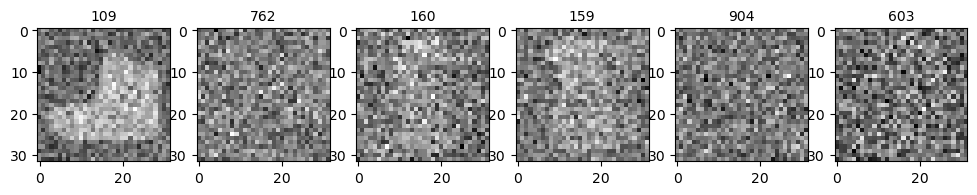

In [3]:
batch = torch.stack([ds[idx] for idx in range(6)])
z_ts, steps, noises = scheduler.add_noise(batch) 
show_images(z_ts, steps)

Note que a maioria das imagens possui bastante ruído. Isso faz sentido, o modelo será treinado para remover o ruído dessas imagens, então é importante que o problema não seja trivial.

In [4]:
def collate_fn(batch): 
    '''Função para podermos utilizar um dataloader com as imagens ruidosas.
    Ela recebe um batch de imagens, aplica o ruído e retorna as imagens ruidosas,
    o nível de ruído aplicado nas imagens e o ruído.'''

    batch = torch.stack(batch, 0)
    z_ts, steps, noises = scheduler.add_noise(batch)
    
    return z_ts, steps, noises

dl = DataLoader(ds, batch_size=4, shuffle=False, collate_fn=collate_fn)
z_ts, steps, noises = next(iter(dl))
print(z_ts.shape, steps.shape, noises.shape)

torch.Size([4, 1, 32, 32]) torch.Size([4]) torch.Size([4, 1, 32, 32])


### Modelo para previsão do ruído

Utilizaremos um modelo UNet do Hugginface. Esse modelo é parecido com o modelo codificador-decodificador que fizemos na aula sobre autoencoders. Ele recebe como entrada uma imagem, codifica a imagem e decodifica para o mesmo tamanho da imagem de entrada.

In [5]:
from diffusers import UNet2DModel

model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 256), norm_num_groups=8)
model

i:\Miniconda3\envs\vc2024\Lib\site-packages\diffusers\utils\outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): LoRACompatibleLinear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): LoRACompatibleLinear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(8, 32, eps=1e-05, affine=True)
          (conv1): LoRACompatibleConv(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): LoRACompatibleLinear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(8, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): LoRACompatibleConv(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(

### Treinamento

O treinamento do modelo consiste em apresentar como entrada um batch de imagens e o modelo aprenderá a prever o ruído presente na imagem. Note que o modelo prevê o ruído, ele não prevê a imagem sem ruído como fizemos em outro aula. Alguns outros métodos envolvem a previsão da imagem original, mas o modelo DDPM realiza a previsão do ruído.

In [6]:
# Esta célula demora para executar. É possível carregar o modelo treinado na 
# célula abaixo

def train_step(model, dl, device, loss_func, optim, scheduler):
    '''Passo de treinamento'''

    model.train()
    loss_log = 0.
    for idx, (imgs, steps, noises) in enumerate(dl):
        imgs = imgs.to(device)
        steps = steps.to(device)
        noises = noises.to(device)
        optim.zero_grad()
        # O modelo recebe as imagens e os níveis de ruído presentes nas imagens
        scores = model(imgs, steps).sample
        # A loss compara o ruído previsto pela rede com o ruído adicionado
        loss = loss_func(scores, noises)
        loss.backward()
        optim.step()
        loss_log += loss.detach()*imgs.shape[0]

    scheduler.step()
    loss_log /= len(dl.dataset)

    return loss_log.item()

def train(model, ds, bs, num_epochs, lr):
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    dl = DataLoader(ds, batch_size=bs, shuffle=True, collate_fn=collate_fn)
    loss_func = nn.MSELoss()
    #optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9) 
    optim = torch.optim.Adam(model.parameters(), lr=lr, eps=1e-5) 
    sched = torch.optim.lr_scheduler.PolynomialLR(optim, num_epochs)
    for epoch in range(0, num_epochs):
        loss = train_step(model, dl, device, loss_func, optim, sched)
        print(epoch, loss)

#train(model, ds, bs=512, num_epochs=25, lr=0.001)
#torch.save(model.state_dict(), '../data/checkpoints/M11/checkpoint.pt')

In [7]:
device = 'cuda'
model.load_state_dict(torch.load('../data/checkpoints/M11/checkpoint.pt'))
model.to(device);

### Geração de imagens usando o modelo treinado

In [9]:
@torch.no_grad()
def sample(model, scheduler, shape):
    '''Gera um batch de imagens de tamanho `shape`.'''

    device = model.device
    n_steps = scheduler.n_steps

    # Ruído aleatório inicial
    z_t = torch.randn(shape)
    preds = {n_steps:z_t}
    z_t = z_t.to(device)
    for step in reversed(range(n_steps)):
        # Cria um batch com o valor de step
        step_batch = torch.full((z_t.shape[0],), step, device=device, dtype=torch.long)
        # Aplica o modelo na imagem com ruído. O modelo também recebe o nível de ruído
        # da imagem, pois isso ajuda o modelo a prever o ruído
        # O modelo do Hugginface retorna um objeto no qual o atributo .sample
        # possui o resultado
        noise = model(z_t, step_batch).sample
        # Gera uma imagem um pouco menos ruidosa
        z_t = scheduler.step(noise, step, z_t)
        preds[step] = z_t.cpu()

    return preds

samples = sample(model, scheduler, (6, 1, 32, 32))

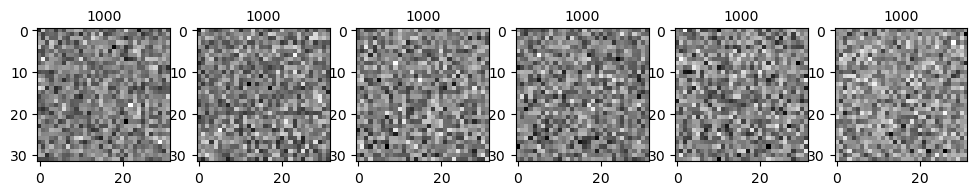

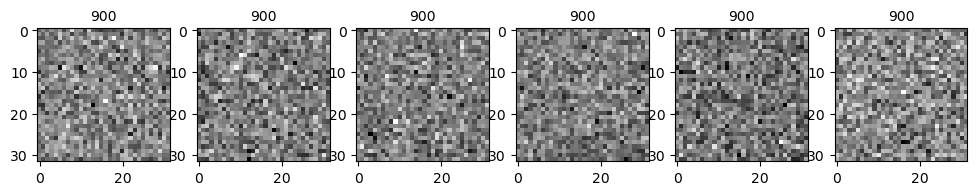

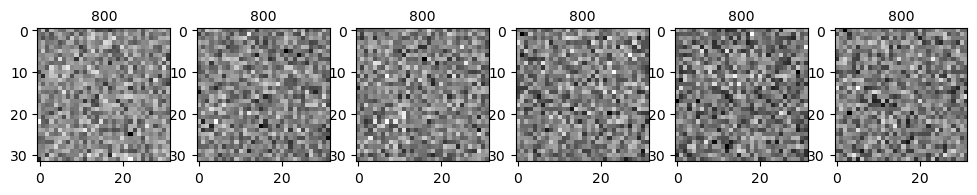

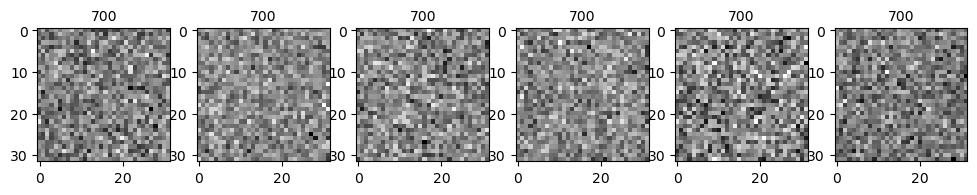

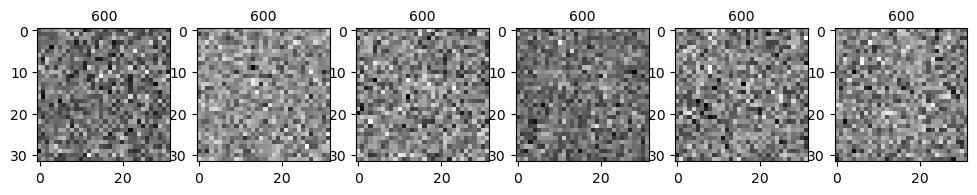

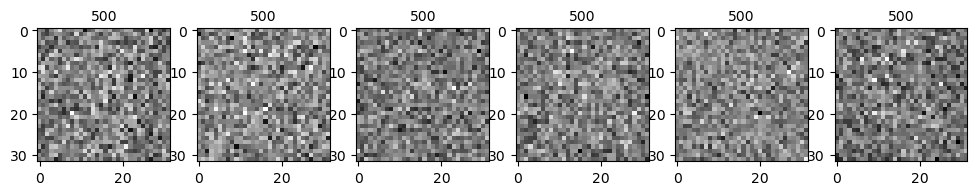

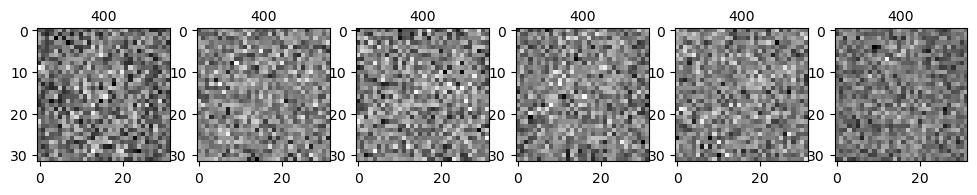

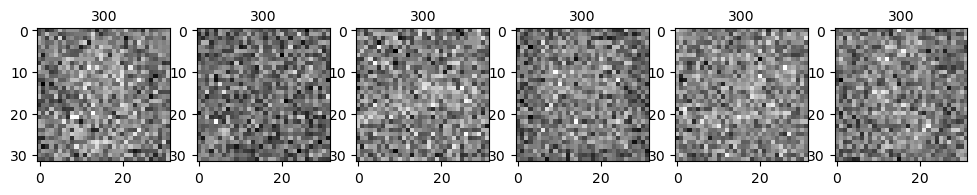

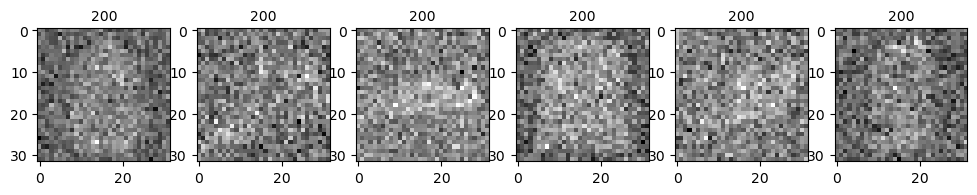

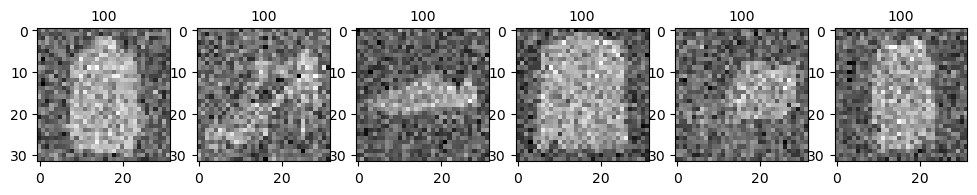

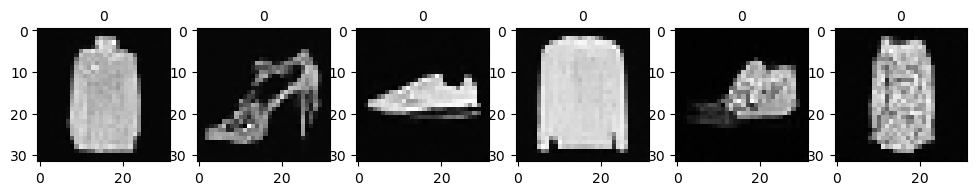

In [10]:
for step in reversed(range(0, n_steps+1, 100)):
    samples_t = samples[step]
    show_images(samples_t, [torch.tensor(step)]*6)